# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

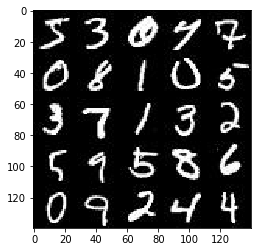

In [2]:
show_n_images = 35

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

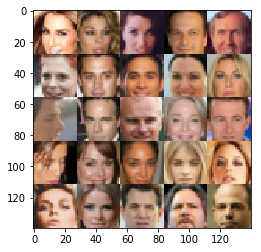

In [3]:
show_n_images = 35

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/martijnde/anaconda3linux/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_shape = (None, image_width, image_height, image_channels)
    
    real_inputs = tf.placeholder(tf.float32, shape=real_shape, name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')
    
    return(real_inputs, z_inputs, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np

GEN_SCOPE = 'generator'
DISC_SCOPE = 'discriminator'
ALPHA = 0.2
FLAT_SHAPE = (7, 7, 224)
FLAT_PRODUCT = np.prod(FLAT_SHAPE)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Example found and used from: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def conv_layer(layer, filters, apply_batch_norm=True, kernel_size=5, strides=2):
        layer = tf.layers.conv2d(layer, filters, kernel_size, strides, padding='same')
        if apply_batch_norm:
            layer = tf.layers.batch_normalization(layer, training=True)
        return tf.maximum(ALPHA * layer, layer)
    def fully_connected(layer):
        shape = np.prod(layer.shape[1:]).value
        flat  = tf.reshape(layer, (-1, shape))
        return tf.layers.dense(flat, 1)

    with tf.variable_scope(DISC_SCOPE, reuse=reuse):
        layer = images
        for conv_args in [
            (56,  True),
            (112, False),
            (224, False)
        ]:
            layer = conv_layer(layer, *conv_args)
        logits = fully_connected(layer)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Example found and used from: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def fully_connected(layer):
        layer = tf.layers.dense(z, np.prod(FLAT_SHAPE))
        return tf.reshape(layer, (-1, *FLAT_SHAPE))
    def conv_transpose_layer(layer, filters, kernel_size=5, strides=2):
        if isinstance(filters, int):
            layer = tf.layers.conv2d_transpose(layer, filters, kernel_size, strides, padding='same')
        layer = tf.layers.batch_normalization(layer, training=is_train)
        return tf.maximum(ALPHA * layer, layer)
    
    with tf.variable_scope(GEN_SCOPE, reuse=not is_train):
        layer = fully_connected(z)
        for conv_args in [
            (None, 0, 0),
            (224,  5, 2),
        ]:
            layer = conv_transpose_layer(layer, *conv_args)
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Example found and used from: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    gen_model                         = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)

    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_real, labels=tf.ones_like(disc_model_real)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_fake, labels=tf.zeros_like(disc_model_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disc_logits_fake, labels=tf.ones_like(disc_model_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake

    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Example found and used from: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    def is_in(scope_name, var):
        return var.name.startswith(scope_name)
    trainables = tf.trainable_variables()
    disc_vars = [var for var in trainables if is_in(DISC_SCOPE, var)]
    gen_vars  = [var for var in trainables if is_in(GEN_SCOPE, var)]
    
    # https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Solutions.ipynb
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt  = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)

        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
PRINT_EVERY = 15
SHOW_EVERY = 100
SHOW_COUNT = 15

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Example code found and used from: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb
    
    def print_progress():
        train_loss_d = disc_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
        train_loss_g = gen_loss.eval({z_inputs: batch_z})
        
        print("Epoch {}/{}...".format(epoch_i + 1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
    def show_progress():
        show_generator_output(sess, SHOW_COUNT, z_inputs, out_channel_dim, data_image_mode)
    def generate_noise():
        return np.random.uniform(-1, 1, size=(batch_size, z_dim))
        
    out_channel_dim          = data_shape[-1]
    real_inputs, z_inputs, _ = model_inputs(*data_shape[1:], z_dim)
    disc_loss, gen_loss      = model_loss(real_inputs, z_inputs, out_channel_dim)
    disc_opt,  gen_opt       = model_opt(disc_loss, gen_loss, learning_rate, beta1)

    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    step     = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2.0 # NOTE: Normalizes image ranges
                batch_z      = generate_noise()

                sess.run(disc_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z})
                sess.run(gen_opt,  feed_dict={real_inputs: batch_images, z_inputs: batch_z})

                if step % PRINT_EVERY == 0:
                    print_progress()
                if step % SHOW_EVERY == 0:
                    show_progress()            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 4.8027
Epoch 1/2... Discriminator Loss: 4.9014... Generator Loss: 0.0196
Epoch 1/2... Discriminator Loss: 0.2849... Generator Loss: 1.8368
Epoch 1/2... Discriminator Loss: 1.8309... Generator Loss: 0.2629
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 1.1473


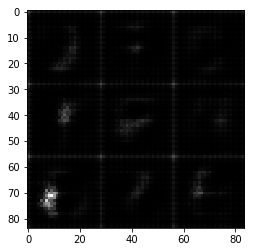

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.0512
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.6105
Epoch 1/2... Discriminator Loss: 0.9462... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 1.0262
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.1815


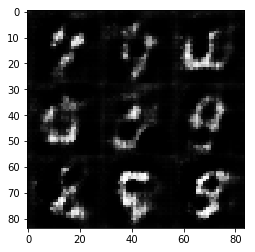

Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.5501
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.9872
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.1958... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.8629


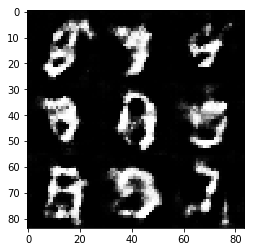

Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 2.1683
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.5300
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.3962
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.3116


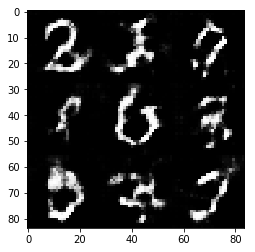

Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.2395
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.2781
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.0984
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.6953


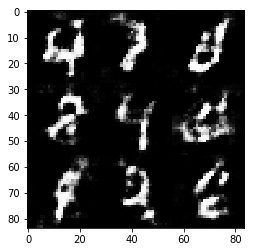

Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 0.9860
Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 1.0164... Generator Loss: 0.8189
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 1.1203
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.9149


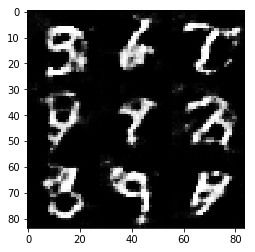

Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 1.2682
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 0.9758


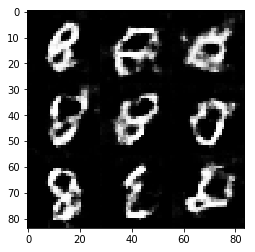

Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.7556
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.1708
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 0.9428... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 1.0704


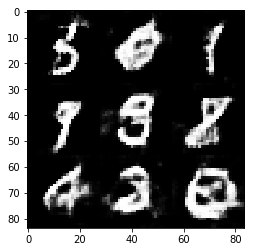

Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 0.7714... Generator Loss: 1.5256
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 1.6405
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 1.4052
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 0.9129


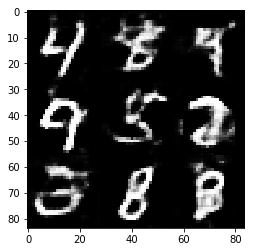

Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.0381
Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 1.8526
Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 0.8643... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.7300


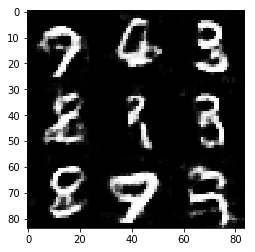

Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.5603... Generator Loss: 2.9775
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.0803


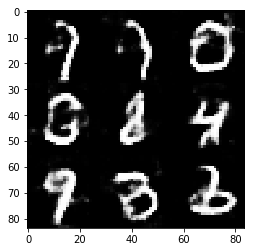

Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.8444
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 1.2933
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.1151
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.0200


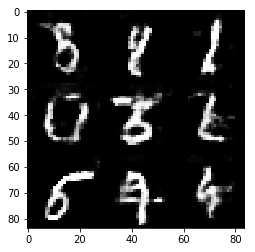

Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.0702
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.4130


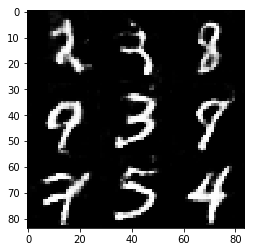

Epoch 2/2... Discriminator Loss: 0.7547... Generator Loss: 1.3381
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 2.1377
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.8687
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.4644


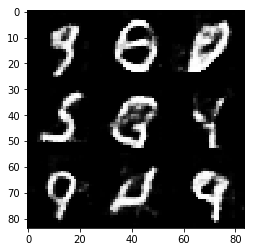

Epoch 2/2... Discriminator Loss: 1.1877... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.3162
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.6911
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.2578
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 2.3820


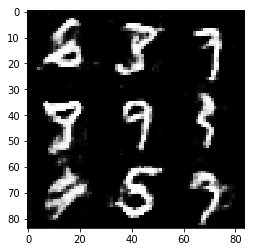

Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.2587
Epoch 2/2... Discriminator Loss: 0.7618... Generator Loss: 2.0804
Epoch 2/2... Discriminator Loss: 0.9407... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 0.8408
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 0.6318


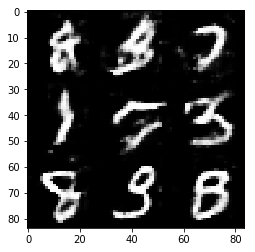

Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.3128
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.8914
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 2.4333
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.3570
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 1.0043
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 2.4944
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 1.3680


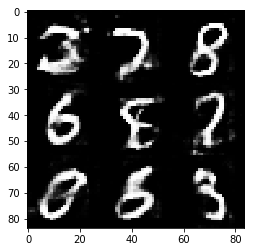

Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 0.9072... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 2.2933
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.2671... Generator Loss: 0.5542
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 0.9649


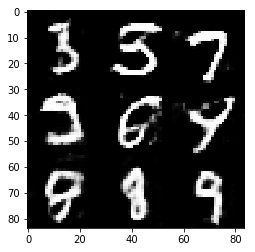

Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 1.4205
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.2605
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.3820


In [12]:
# I used 512 batch size, this was way to high I noticed during testing, thus GAN's are very sensitive to batch sizes I noticed

batch_size = 64
z_dim = 75
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 8.9639
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 15.3397
Epoch 1/1... Discriminator Loss: 0.0770... Generator Loss: 13.2968
Epoch 1/1... Discriminator Loss: 3.3937... Generator Loss: 23.6136
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.6934
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 2.1413


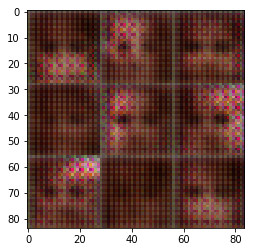

Epoch 1/1... Discriminator Loss: 0.5980... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.1974
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 2.9659
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 1.5027


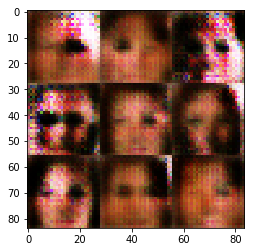

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 0.7120... Generator Loss: 3.6388
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 4.2377
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.7784
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 3.2492
Epoch 1/1... Discriminator Loss: 0.4460... Generator Loss: 4.6591


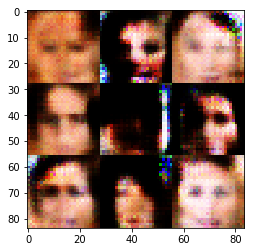

Epoch 1/1... Discriminator Loss: 1.9097... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.8775
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 2.4470
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.8439
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 1.8057


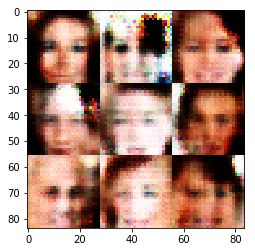

Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 3.4708
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 2.4414
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 3.3150
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.7796
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.9662


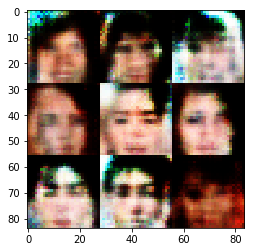

Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.5620
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 3.8376
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.8524
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 2.1627


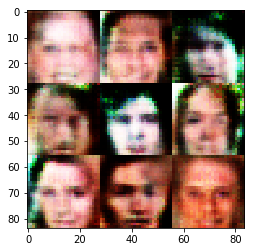

Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 1.8734
Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.9063
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.9392
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 2.5643... Generator Loss: 0.1675


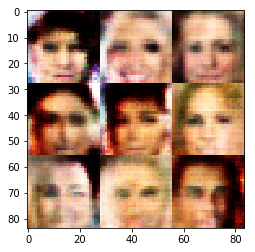

Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 3.3041
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.5975
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 2.6441
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.1090


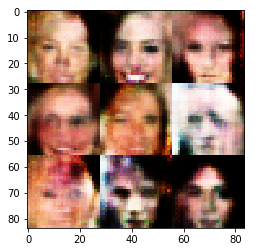

Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.6459... Generator Loss: 1.7563
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.1375


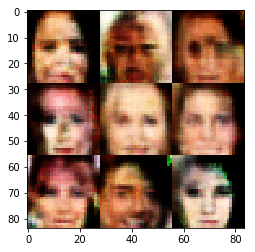

Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 2.6411
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.4460
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.7487... Generator Loss: 3.7216


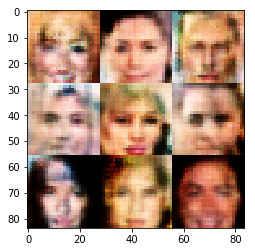

Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.2817
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.8734
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 1.5654
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 2.3644


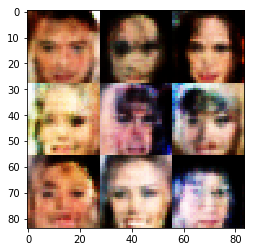

Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 2.8408
Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 0.9603


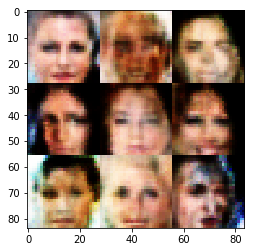

Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.0340
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 2.0630
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.4420


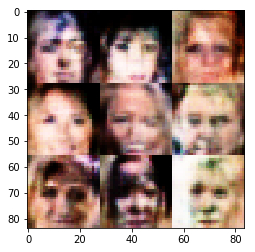

Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.6574
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.0508


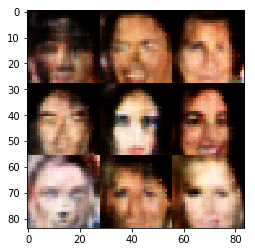

Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.6421... Generator Loss: 2.0817
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.9718... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.6636


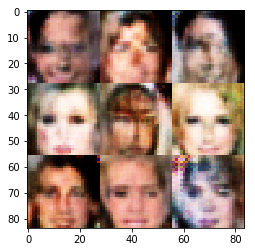

Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.2381
Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 2.4166
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9133


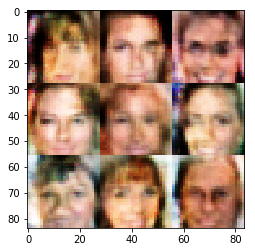

Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.6141
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 2.5369
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.2901


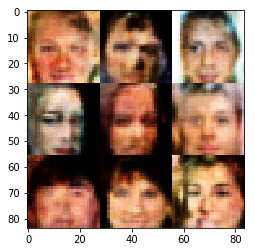

Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 2.7437
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 2.1513
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 2.6352
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.4108


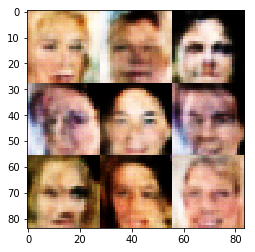

Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.3505
Epoch 1/1... Discriminator Loss: 1.8311... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.6729


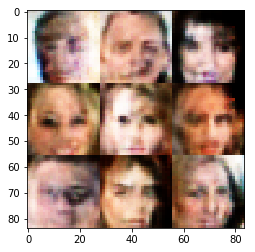

Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 1.6255
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 0.7599... Generator Loss: 1.2653


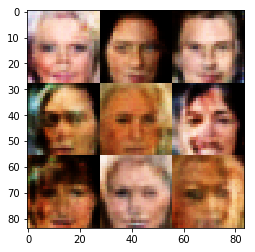

Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.0674


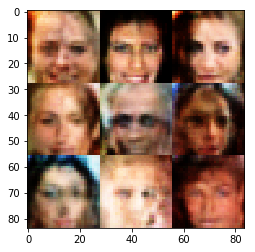

Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 1.4995
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 2.6401
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.3332


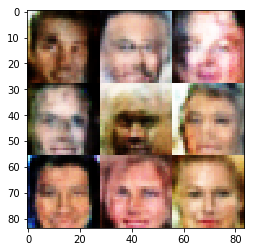

Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 2.7645
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 1.6807... Generator Loss: 2.7706
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.4594
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.1964


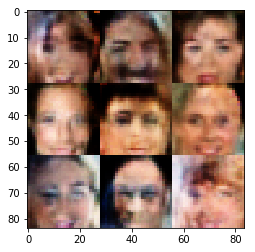

Epoch 1/1... Discriminator Loss: 0.8038... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.2825
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6417


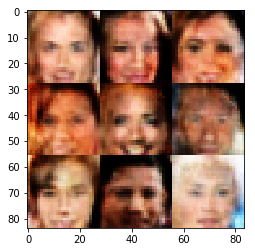

Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 2.7104... Generator Loss: 2.8934
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.6734


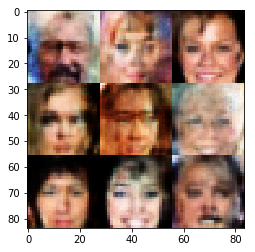

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 0.6127... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.9221
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.7273


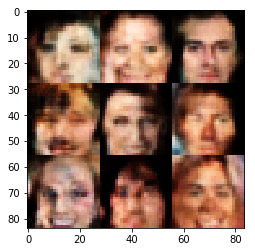

Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 2.1818
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 3.1490
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.8391
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.5339
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.4479
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.7207


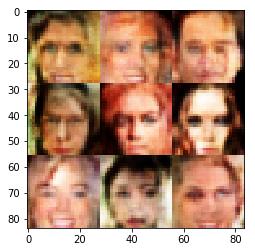

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 1.5301
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.8110
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 2.2125
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.6166
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.1557


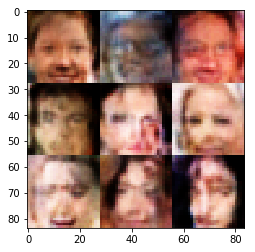

Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.1173
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 2.4711
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5567


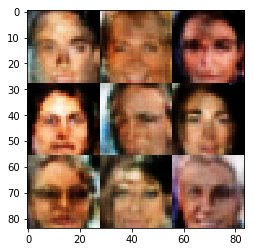

Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.2645
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 0.8620... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 0.9932


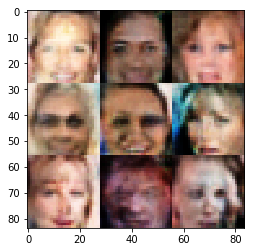

Epoch 1/1... Discriminator Loss: 0.8473... Generator Loss: 1.1445
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 2.4721
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8624


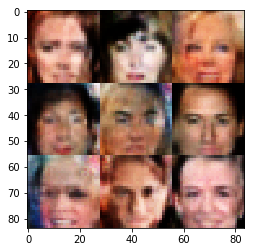

Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 2.0323... Generator Loss: 1.9042
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.5707
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.3533


In [13]:
# I used 512 batch size, this was way to high I noticed during testing, thus GAN's are very sensitive to batch sizes I noticed

batch_size = 64
z_dim = 75
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.